In [30]:
import matplotlib.pyplot as plt
import numpy as np
from AnalyticFormulas import blackScholesPrice
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from math import ceil
from functools import partial


## Option Prices

In [31]:
r = 0.07
sigma = 0.2
s = 80
T = 1.
strikes = np.linspace(40, 300, 10000)
moneyness = s / strikes
prices = np.array([blackScholesPrice(s, r, sigma, T, k) for k in strikes])
pricesNorm = prices / strikes

Text(0.5, 1.0, 'Normalized Call Prices in Black Scholes Model')

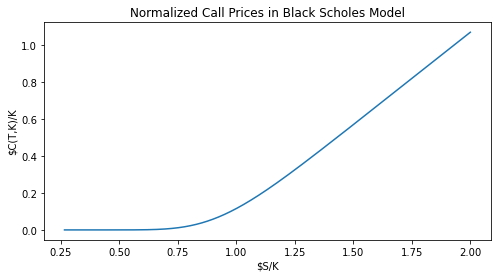

In [32]:
plt.figure(figsize=(8,4))
plt.plot(moneyness, pricesNorm)
plt.xlabel('$S/K')
plt.ylabel('$C(T,K)/K')
plt.title('Normalized Call Prices in Black Scholes Model')

## Neural Net

In [33]:
X = np.reshape(moneyness, (len(moneyness), 1))
y = pricesNorm
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [34]:
def create_model(nWeights=100, hidden_layers=1, learning_rate=0.001):
    # formulas derived from nWeights = sum (d(l-1)+1)*d(l) for all layers l with output dim d(l)
    if hidden_layers == 1: # 100% of neurons in first hidden layer
        neurons = [ceil((nWeights - 1) / 3)]
    elif hidden_layers == 2: # 70% / 30% split of neurons
        x = 1/7 * (np.sqrt(21 * nWeights + 79) - 10)
        neurons = list(map(ceil,[7/3 * x, x]))
    elif hidden_layers == 3: # 50% / 30% / 20% split
        x = 1/21 * (np.sqrt(84 * nWeights + 205) - 17)
        neurons = list(map(ceil, [5/2 * x, 3/2 * x, x]))
    else:
        raise Exception('Only 1, 2 or 3 layers allowed')
        
    model = Sequential([Dense(neurons[0], activation='relu', input_dim=1)])
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model


In [35]:
earlyStop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


creator = partial(create_model, nWeights=100)

batch_size = [10, 30, 80, 150, 300, 700, 1200, 2000]
learning_rate = [0.1, 0.01, 0.002, 0.001]
hidden_layers = [1, 2, 3]

model = KerasRegressor(create_model, epochs=2000, verbose=0)

p_grid = dict(hidden_layers=hidden_layers, batch_size=batch_size, learning_rate=learning_rate)

grid = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, cv=3, verbose=10)
grid_result = grid.fit(X_train, y_train, callbacks=[earlyStop])



Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3; 1/96] START batch_size=10, hidden_layers=1, learning_rate=0.1..........
[CV 1/3; 1/96] END batch_size=10, hidden_layers=1, learning_rate=0.1; total time=   4.6s
[CV 2/3; 1/96] START batch_size=10, hidden_layers=1, learning_rate=0.1..........
[CV 2/3; 1/96] END batch_size=10, hidden_layers=1, learning_rate=0.1; total time=   2.8s
[CV 3/3; 1/96] START batch_size=10, hidden_layers=1, learning_rate=0.1..........
[CV 3/3; 1/96] END batch_size=10, hidden_layers=1, learning_rate=0.1; total time=   2.3s
[CV 1/3; 2/96] START batch_size=10, hidden_layers=1, learning_rate=0.01.........
[CV 1/3; 2/96] END batch_size=10, hidden_layers=1, learning_rate=0.01; total time=   2.6s
[CV 2/3; 2/96] START batch_size=10, hidden_layers=1, learning_rate=0.01.........
[CV 2/3; 2/96] END batch_size=10, hidden_layers=1, learning_rate=0.01; total time=   2.3s
[CV 3/3; 2/96] START batch_size=10, hidden_layers=1, learning_rate=0.01.........
[CV 3

In [38]:
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -9.967267544652714e-07 using {'batch_size': 2000, 'hidden_layers': 1, 'learning_rate': 0.01}
-0.000276 (0.000100) with: {'batch_size': 10, 'hidden_layers': 1, 'learning_rate': 0.1}
-0.000003 (0.000002) with: {'batch_size': 10, 'hidden_layers': 1, 'learning_rate': 0.01}
-0.000006 (0.000007) with: {'batch_size': 10, 'hidden_layers': 1, 'learning_rate': 0.002}
-0.000033 (0.000040) with: {'batch_size': 10, 'hidden_layers': 1, 'learning_rate': 0.001}
-0.015906 (0.022127) with: {'batch_size': 10, 'hidden_layers': 2, 'learning_rate': 0.1}
-0.000009 (0.000011) with: {'batch_size': 10, 'hidden_layers': 2, 'learning_rate': 0.01}
-0.000005 (0.000002) with: {'batch_size': 10, 'hidden_layers': 2, 'learning_rate': 0.002}
-0.000104 (0.000015) with: {'batch_size': 10, 'hidden_layers': 2, 'learning_rate': 0.001}
-0.040665 (0.006471) with: {'batch_size': 10, 'hidden_layers': 3, 'learning_rate': 0.1}
-0.000143 (0.000138) with: {'batch_size': 10, 'hidden_layers': 3, 'learning_rate': 0.01}
-0.000043 

In [37]:
grid_result.best_score_

-9.967267544652714e-07

In [42]:
import sklearn